## 第8章 2基于线性层的自编码模型

**Daitu：2505131775@qq.com**

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
## 导入本章所需要的模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import hiddenlayer as hl
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report,accuracy_score

import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid


使用手写字体数据集，利用自编码模型对数据降维和重构

使用编码降维后的数据特征＋SVM分类器进行分类，将分类的结果和使用其他降维方法＋SVM的预测结果进行比较

### 数据准备

In [3]:
## 使用手写体数据
## 准备训练数据集
train_data  = MNIST(
    root = "./data/MNIST", # 数据的路径
    train = True, # 只使用训练数据集
    transform  = transforms.ToTensor(),
    download= False
)
## 将图像数据转化为向量数据
train_data_x = train_data.data.type(torch.FloatTensor) / 255.0
train_data_x = train_data_x.reshape(train_data_x.shape[0],-1)
train_data_y = train_data.targets
# train_data = Data.TensorDataset(train_data_x)

## 定义一个数据加载器
train_loader = Data.DataLoader(
    dataset = train_data_x, ## 使用的数据集
    batch_size=64, # 批处理样本大小
    shuffle = True, # 每次迭代前打乱数据
    num_workers = 2, # 使用两个进程 
)
## 对测试数据集进行导入
test_data = MNIST(
    root = "./data/MNIST", # 数据的路径
    train = False, # 只使用训练数据集
    transform  = transforms.ToTensor(),
    download= False
)
## 为测试数据添加一个通道纬度,获取测试数据的X和Y
test_data_x = test_data.data.type(torch.FloatTensor) / 255.0
test_data_x = test_data_x.reshape(test_data_x.shape[0],-1)
test_data_y = test_data.targets
print("训练数据集:",train_data_x.shape)
print("测试数据集:",test_data_x.shape)

训练数据集: torch.Size([60000, 784])
测试数据集: torch.Size([10000, 784])


### 可视化部分图像数据

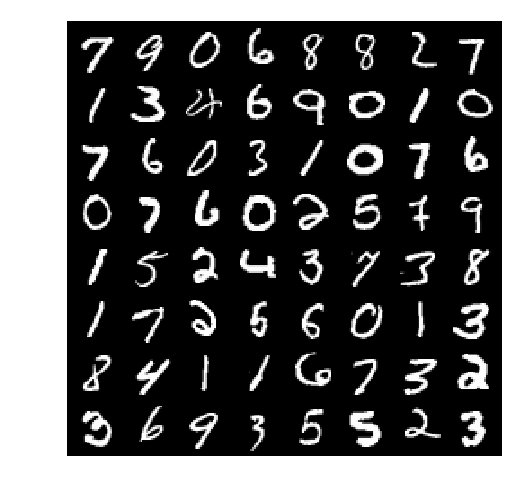

In [4]:
## 可视化一个batch的图像内容
##  获得一个batch的数据
for step, b_x in enumerate(train_loader):  
    if step > 0:
        break

## 可视化一个batch的图像
im = make_grid(b_x.reshape((-1,1,28,28)))
im = im.data.numpy().transpose((1,2,0))
plt.figure()
plt.imshow(im)
plt.axis("off")
plt.show()

### 使用Liner()层搭建自编吗网络

In [5]:
class EnDecoder(nn.Module):
    def __init__(self):
        super(EnDecoder,self).__init__()
        ## 定义Encoder
        self.Encoder = nn.Sequential(
            nn.Linear(784,512),
            nn.Tanh(),
            nn.Linear(512,256),
            nn.Tanh(),
            nn.Linear(256,128),
            nn.Tanh(),
            nn.Linear(128,3), 
            nn.Tanh(),
        )
        ## 定义Decoder
        self.Decoder = nn.Sequential(
            nn.Linear(3,128),
            nn.Tanh(),
            nn.Linear(128,256),
            nn.Tanh(),
            nn.Linear(256,512),
            nn.Tanh(),
            nn.Linear(512,784),  
            nn.Sigmoid(),
        )

    ## 定义网络的向前传播路径   
    def forward(self, x):
        encoder = self.Encoder(x)
        decoder = self.Decoder(encoder)
        return encoder,decoder
    
## 输出我们的网络结构
edmodel = EnDecoder()
print(edmodel)

EnDecoder(
  (Encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=3, bias=True)
    (7): Tanh()
  )
  (Decoder): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): Tanh()
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


### 使用训练数据进行训练


In [6]:
len(train_loader)
## 训练集一共有938个batch，使用前百分子75的batch作为训练集，剩余的batch作为测试集

938

In [7]:
np.int(len(train_loader)*0.75)

703

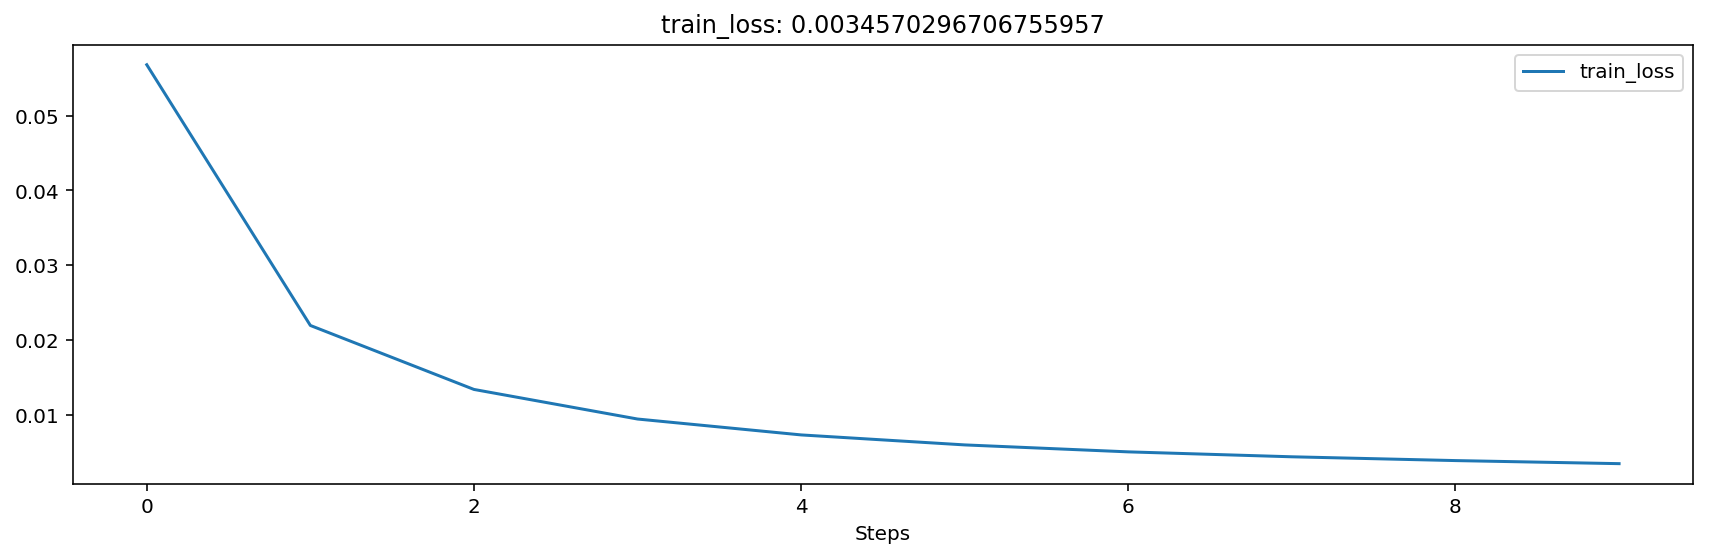

In [8]:
# 定义优化器
optimizer = torch.optim.Adam(edmodel.parameters(), lr=0.003)  
loss_func = nn.MSELoss()   # 损失函数
# 记录训练过程的指标
history1 = hl.History()
# 使用Canvas进行可视化
canvas1 = hl.Canvas()
train_num = 0
val_num = 0
## 对模型进行迭代训练,对所有的数据训练EPOCH轮
for epoch in range(10):
    train_loss_epoch = 0
    ## 对训练数据的迭代器进行迭代计算
    for step, b_x in enumerate(train_loader): 
        ## 使用每个batch进行训练模型
        _,output = edmodel(b_x)         # 在训练batch上的输出
        loss = loss_func(output, b_x)   # 平方根误差
        optimizer.zero_grad()           # 每个迭代步的梯度初始化为0
        loss.backward()                 # 损失的后向传播，计算梯度
        optimizer.step()                # 使用梯度进行优化
        train_loss_epoch += loss.item() * b_x.size(0)
        train_num = train_num+b_x.size(0)
    ## 计算一个epoch的损失
    train_loss = train_loss_epoch / train_num
    ## 保存每个epoch上的输出loss
    history1.log(epoch,train_loss=train_loss)
    # 可视网络训练的过程
    with canvas1:
        canvas1.draw_plot(history1["train_loss"])


### 可视化部分测试集编码前后的图像

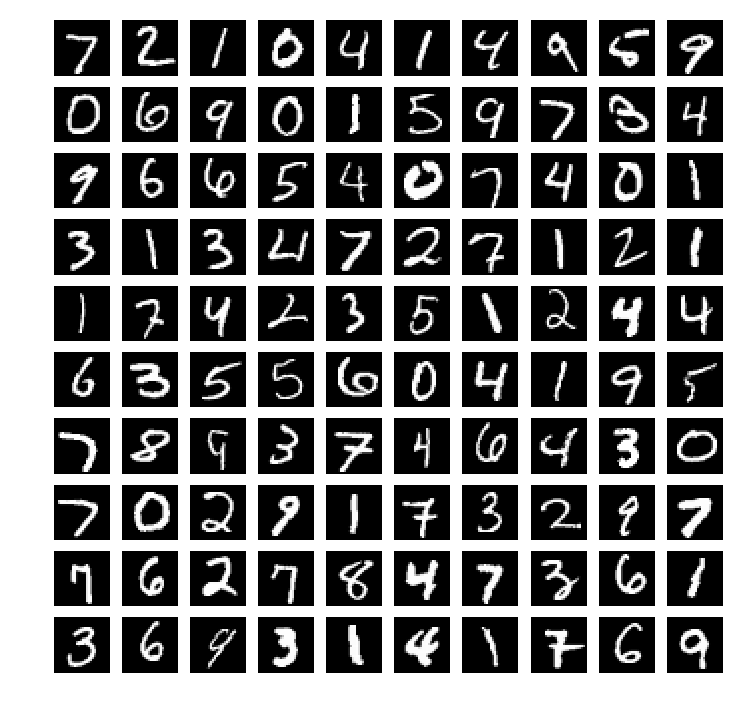

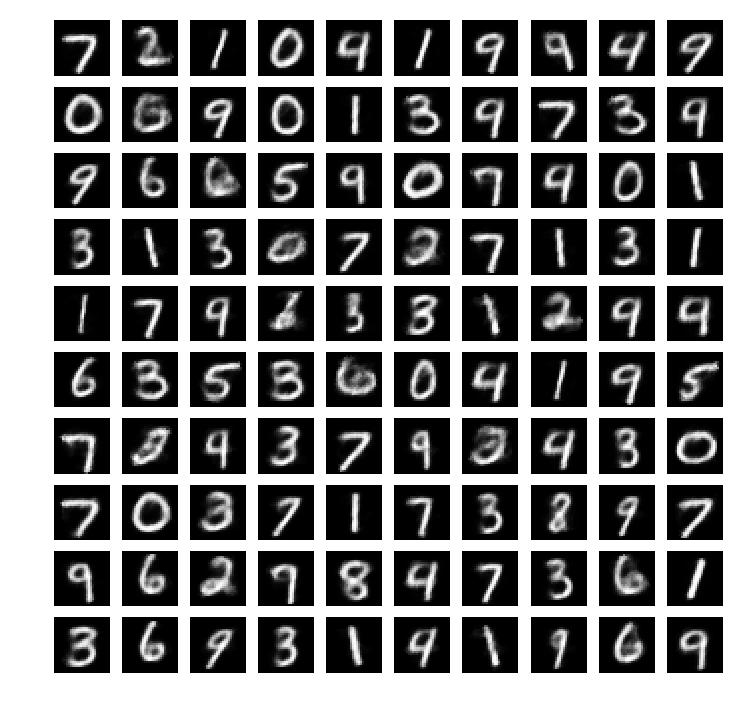

In [9]:
## 预测测试集前100张图像的输出
edmodel.eval()
_,test_decoder = edmodel(test_data_x[0:100,:])
## 可视化原始后的图像
plt.figure(figsize=(6,6))
for ii in range(test_decoder.shape[0]):
    plt.subplot(10,10,ii+1)
    im = test_data_x[ii,:]
    im = im.data.numpy().reshape(28,28)
    plt.imshow(im,cmap=plt.cm.gray)
    plt.axis("off")
plt.show()
## 可视化编码后的图像
plt.figure(figsize=(6,6))
for ii in range(test_decoder.shape[0]):
    plt.subplot(10,10,ii+1)
    im = test_decoder[ii,:]
    im = im.data.numpy().reshape(28,28)
    plt.imshow(im,cmap=plt.cm.gray)
    plt.axis("off")
plt.show()

In [10]:
## 获取前500个样本的自编吗后的特征，并对数据进行可视化
edmodel.eval()
TEST_num = 500
test_encoder,_ = edmodel(test_data_x[0:TEST_num,:])
print("test_encoder.shape:",test_encoder.shape)

test_encoder.shape: torch.Size([500, 3])


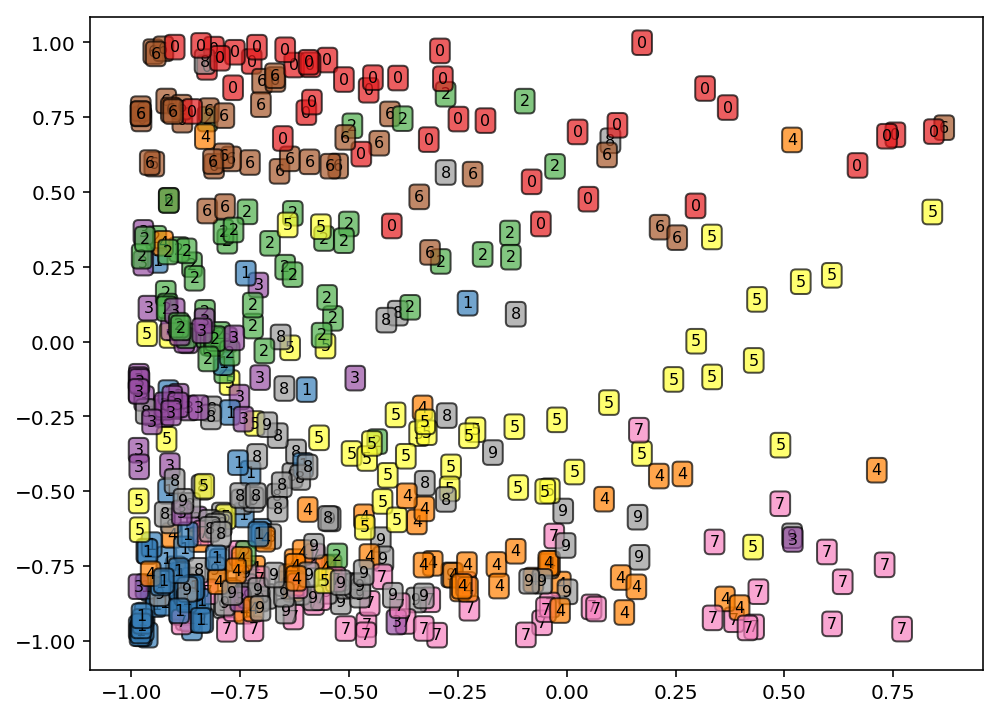

In [11]:
test_encoder_arr = test_encoder.data.numpy()
## 将前2个纬度的特征进行可视化
X = test_encoder_arr[:,0]
Y = test_encoder_arr[:,1]
plt.figure(figsize=(8,6))
# 可视化前设置坐标系的取值范围
plt.xlim([min(X)-0.1,max(X)+0.1])
plt.ylim([min(Y)-0.1,max(Y)+0.1])
for ii in range(test_encoder.shape[0]):
    text = test_data_y.data.numpy()[ii]
    plt.text(X[ii],Y[ii],str(text),fontsize=8,
            bbox=dict(boxstyle="round",facecolor=plt.cm.Set1(text), alpha=0.7))
plt.show()

In [12]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

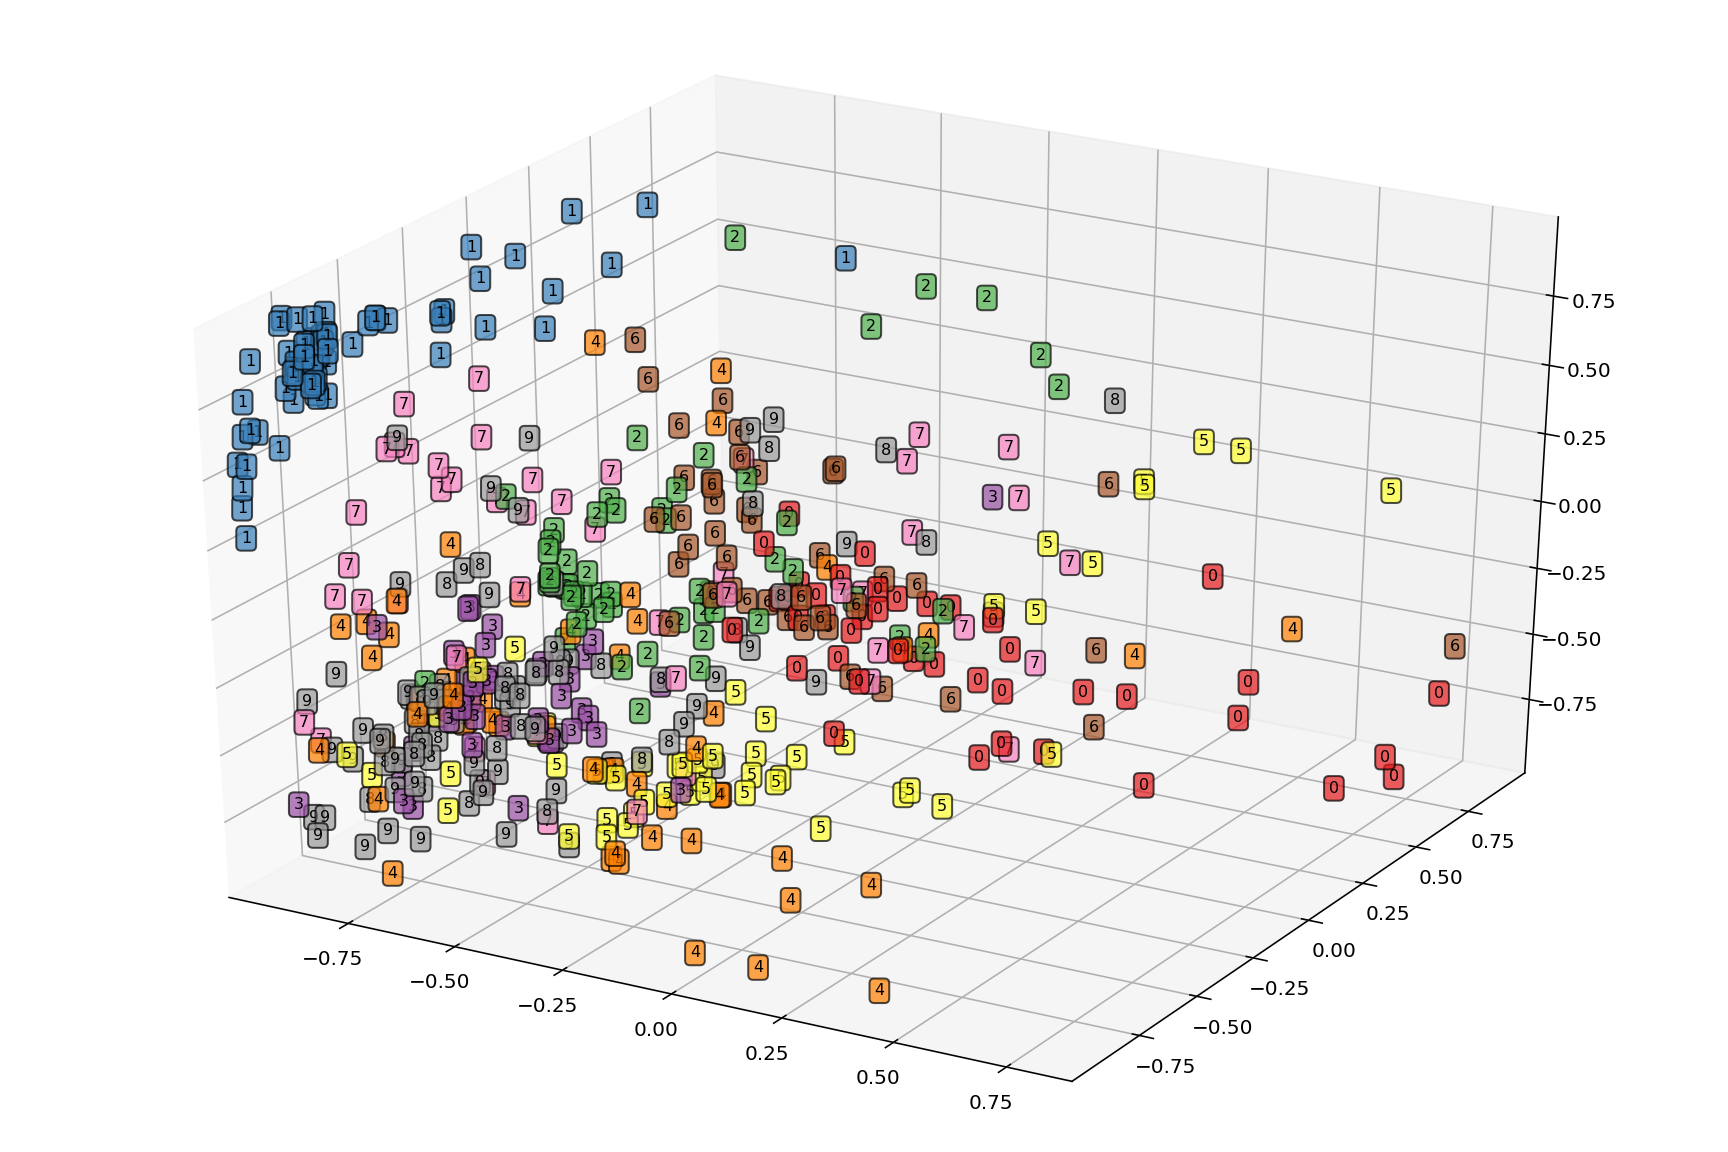

In [13]:
## 将3个纬度的特征进行可视化
test_encoder_arr = test_encoder.data.numpy()
fig = plt.figure(figsize=(12,8))
ax1 = Axes3D(fig)
X = test_encoder_arr[:,0]
Y = test_encoder_arr[:,1]
Z = test_encoder_arr[:,2]
ax1.set_xlim([min(X),max(X)])
ax1.set_ylim([min(Y),max(Y)])
ax1.set_zlim([min(Z),max(Z)])
for ii in range(test_encoder.shape[0]):
    text = test_data_y.data.numpy()[ii]
    ax1.text(X[ii],Y[ii,],Z[ii],str(text),fontsize=8,
             bbox=dict(boxstyle="round",facecolor=plt.cm.Set1(text), alpha=0.7))
plt.show()

### 自编码后的特征＋SVM  VS  PCA降维＋SVM分类的效果对比

#### 数据准备

In [14]:
## 自编码后的特征训练集和测试集
train_ed_x,_ = edmodel(train_data_x)
train_ed_x = train_ed_x.data.numpy()
train_y = train_data_y.data.numpy()
test_ed_x,_ = edmodel(test_data_x)
test_ed_x = test_ed_x.data.numpy()
test_y = test_data_y.data.numpy()
print(train_ed_x.shape)
print(train_y.shape)

(60000, 3)
(60000,)


In [15]:
## PCA降维获得的训练集和测试集前3个主成分
pcamodel = PCA(n_components=3,random_state=10)
train_pca_x= pcamodel.fit_transform(train_data_x.data.numpy())
test_pca_x = pcamodel.transform(test_data_x.data.numpy())
print(train_pca_x.shape)

(60000, 3)


In [16]:
np.sum(pcamodel.explained_variance_ratio_)

0.22969788

#### 建立支持向量机分类器

In [17]:
## 使用自编码数据建立分类器,训练和预测
encodersvc = SVC(kernel="rbf",random_state=123)
encodersvc.fit(train_ed_x,train_y)
edsvc_pre = encodersvc.predict(test_ed_x)
print(classification_report(test_y,edsvc_pre))
print("模型精度",accuracy_score(test_y,edsvc_pre))

             precision    recall  f1-score   support

          0       0.93      0.96      0.95       980
          1       0.97      0.98      0.97      1135
          2       0.88      0.87      0.87      1032
          3       0.74      0.87      0.80      1010
          4       0.75      0.70      0.72       982
          5       0.86      0.73      0.79       892
          6       0.92      0.91      0.92       958
          7       0.93      0.85      0.89      1028
          8       0.79      0.78      0.78       974
          9       0.68      0.75      0.71      1009

avg / total       0.85      0.84      0.84     10000

模型精度 0.8421


In [18]:
## 使用PCA降维数据建立分类器,训练和预测
pcasvc = SVC(kernel="rbf",random_state=123)
pcasvc.fit(train_pca_x,train_y)
pcasvc_pre = pcasvc.predict(test_pca_x)
print(classification_report(test_y,pcasvc_pre))
print("模型精度",accuracy_score(test_y,pcasvc_pre))

             precision    recall  f1-score   support

          0       0.68      0.74      0.71       980
          1       0.93      0.95      0.94      1135
          2       0.50      0.50      0.50      1032
          3       0.65      0.66      0.65      1010
          4       0.41      0.52      0.46       982
          5       0.42      0.30      0.35       892
          6       0.39      0.57      0.47       958
          7       0.53      0.50      0.51      1028
          8       0.40      0.27      0.32       974
          9       0.43      0.33      0.37      1009

avg / total       0.54      0.54      0.54     10000

模型精度 0.5426
